#Importing Necessary Libraries

In [30]:
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, GRU, Dense, Dropout,
    Bidirectional, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import matplotlib.pyplot as plt
import pickle

In [31]:
from datasets import load_dataset

dataset = load_dataset("spawn99/CornellMovieDialogCorpus")


In [32]:
print(dataset)
print(dataset["movie_lines"].column_names)

DatasetDict({
    movie_lines: Dataset({
        features: ['lineID', 'characterID', 'movieID', 'characterName', 'utterance'],
        num_rows: 304713
    })
})
['lineID', 'characterID', 'movieID', 'characterName', 'utterance']


In [33]:
lines = dataset["movie_lines"]["utterance"]
print(lines[:15])

['They do not!', 'They do to!', 'I hope so.', 'She okay?', "Let's go.", 'Wow', "Okay -- you're gonna need to learn how to lie.", 'No', 'I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?', 'Like my fear of wearing pastels?', 'The "real you".', 'What good stuff?', "I figured you'd get to the good stuff eventually.", 'Thank God!  If I had to hear one more story about your coiffure...', "Me.  This endless ...blonde babble. I'm like, boring myself."]


In [34]:
lines = [line for line in lines if line is not None]

MAX_PAIRS = 100000
pairs = []

for i in range(min(len(lines) - 1, MAX_PAIRS)):
    q = lines[i].strip().lower()
    a = lines[i + 1].strip().lower()

    if q and a:
        pairs.append((q, a))

for i, (q, a) in enumerate(pairs[:10]):
    print(f"Question: {q}\nAnswer: {a}\n{'-'*40}")


Question: they do not!
Answer: they do to!
----------------------------------------
Question: they do to!
Answer: i hope so.
----------------------------------------
Question: i hope so.
Answer: she okay?
----------------------------------------
Question: she okay?
Answer: let's go.
----------------------------------------
Question: let's go.
Answer: wow
----------------------------------------
Question: wow
Answer: okay -- you're gonna need to learn how to lie.
----------------------------------------
Question: okay -- you're gonna need to learn how to lie.
Answer: no
----------------------------------------
Question: no
Answer: i'm kidding.  you know how sometimes you just become this "persona"?  and you don't know how to quit?
----------------------------------------
Question: i'm kidding.  you know how sometimes you just become this "persona"?  and you don't know how to quit?
Answer: like my fear of wearing pastels?
----------------------------------------
Question: like my fear of

In [35]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [36]:
pairs=[(preprocess_text(q), preprocess_text(a)) for q,a in pairs]

In [37]:
pairs

[('they do not', 'they do to'),
 ('they do to', 'i hope so'),
 ('i hope so', 'she okay'),
 ('she okay', 'lets go'),
 ('lets go', 'wow'),
 ('wow', 'okay youre gonna need to learn how to lie'),
 ('okay youre gonna need to learn how to lie', 'no'),
 ('no',
  'im kidding you know how sometimes you just become this persona and you dont know how to quit'),
 ('im kidding you know how sometimes you just become this persona and you dont know how to quit',
  'like my fear of wearing pastels'),
 ('like my fear of wearing pastels', 'the real you'),
 ('the real you', 'what good stuff'),
 ('what good stuff', 'i figured youd get to the good stuff eventually'),
 ('i figured youd get to the good stuff eventually',
  'thank god if i had to hear one more story about your coiffure'),
 ('thank god if i had to hear one more story about your coiffure',
  'me this endless blonde babble im like boring myself'),
 ('me this endless blonde babble im like boring myself', 'what crap'),
 ('what crap', 'do you listen

In [38]:
questions = [q for q, a in pairs]
answers = ["<start>" + a + "<end>" for q, a in pairs]

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 15000
MAX_LEN =30

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(questions + answers)

encoder_seq = tokenizer.texts_to_sequences(questions)
decoder_seq = tokenizer.texts_to_sequences(answers)

encoder_seq = pad_sequences(encoder_seq, maxlen=MAX_LEN, padding="post")
decoder_seq = pad_sequences(decoder_seq, maxlen=MAX_LEN, padding="post")


In [40]:
# =============================================================================
# 4. CREATE DECODER INPUT/TARGET (FIXED - THIS WAS MISSING!)
# =============================================================================
decoder_input = decoder_seq[:, :-1]   # All except last token
decoder_target = decoder_seq[:, 1:]    # All except first token (<START>)

# Expand dims for sparse_categorical_crossentropy
decoder_target = np.expand_dims(decoder_target, axis=-1)

print(f"\n✅ Data prepared:")
print(f"encoder_seq shape: {encoder_seq.shape}")
print(f"decoder_input shape: {decoder_input.shape}")
print(f"decoder_target shape: {decoder_target.shape}")



✅ Data prepared:
encoder_seq shape: (100000, 30)
decoder_input shape: (100000, 29)
decoder_target shape: (100000, 29, 1)


In [41]:
# 5. SPLIT WITH SKLEARN
# =============================================================================
train_enc, val_enc, train_dec_in, val_dec_in, train_dec_tgt, val_dec_tgt = train_test_split(
    encoder_seq,
    decoder_input,
    decoder_target,
    test_size=0.2,
    random_state=42
)

print(f"\n✅ Train: {len(train_enc)}, Val: {len(val_enc)}")


✅ Train: 80000, Val: 20000


In [43]:
def create_dataset(encoder_seq, decoder_input, decoder_target, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'encoder_inputs': encoder_seq,
            'decoder_inputs': decoder_input
        },
        decoder_target
    ))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(train_enc, train_dec_in, train_dec_tgt, config.BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_enc, val_dec_in, val_dec_tgt, config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Val batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")


Train batches: 2500
Val batches: 625


In [ ]:
# Clear any previous sessions
keras.backend.clear_session()

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

#==============================================================================
# MODEL ARCHITECTURE
#==============================================================================

class Seq2SeqModel:
    def __init__(self, enc_vocab_size, dec_vocab_size, embedding_dim, units, dropout_rate=0.2):
        self.enc_vocab_size = enc_vocab_size
        self.dec_vocab_size = dec_vocab_size
        self.embedding_dim = embedding_dim
        self.units = units
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self):
        """Build the Seq2Seq model"""

        # ==================== ENCODER ====================
        # Input layer for encoder
        encoder_inputs = layers.Input(shape=(None,), name='encoder_inputs')

        # Embedding layer for encoder (mask_zero=False to avoid cuDNN issues)
        enc_embedding = layers.Embedding(
            input_dim=self.enc_vocab_size,
            output_dim=self.embedding_dim,
            mask_zero=False,  # Changed from True
            name='encoder_embedding'
        )(encoder_inputs)

        # Dropout for regularization
        enc_dropout = layers.Dropout(self.dropout_rate)(enc_embedding)

        # LSTM encoder with cuDNN support
        encoder_lstm = layers.LSTM(
            units=self.units,
            return_state=True,
            return_sequences=False,
            name='encoder_lstm'
        )

        # Get encoder outputs and states
        _, state_h, state_c = encoder_lstm(enc_dropout)
        encoder_states = [state_h, state_c]

        # ==================== DECODER ====================
        # Input layer for decoder
        decoder_inputs = layers.Input(shape=(None,), name='decoder_inputs')

        # Embedding layer for decoder (mask_zero=False to avoid cuDNN issues)
        dec_embedding = layers.Embedding(
            input_dim=self.dec_vocab_size,
            output_dim=self.embedding_dim,
            mask_zero=False,  # Changed from True
            name='decoder_embedding'
        )(decoder_inputs)

        # Dropout for regularization
        dec_dropout = layers.Dropout(self.dropout_rate)(dec_embedding)

        # LSTM decoder with cuDNN support
        decoder_lstm = layers.LSTM(
            units=self.units,
            return_sequences=True,
            return_state=True,
            name='decoder_lstm'
        )

        # Decoder output (using encoder final states as initial states)
        decoder_outputs, _, _ = decoder_lstm(
            dec_dropout,
            initial_state=encoder_states
        )

        # Dropout after LSTM
        decoder_dropout = layers.Dropout(self.dropout_rate)(decoder_outputs)

        # Dense output layer
        decoder_dense = layers.Dense(
            self.dec_vocab_size,
            activation=None,  # We'll use from_logits=True in loss
            name='decoder_output'
        )

        decoder_outputs = decoder_dense(decoder_dropout)

        # ==================== FINAL MODEL ====================
        self.model = keras.Model(
            inputs=[encoder_inputs, decoder_inputs],
            outputs=decoder_outputs,
            name='seq2seq_model'
        )

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model with optimizer and loss"""

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        self.model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return self.model

    def get_callbacks(self, use_validation=True):
        """Setup training callbacks"""

        # Create directories
        os.makedirs('models', exist_ok=True)
        os.makedirs('logs', exist_ok=True)

        monitor = 'val_loss' if use_validation else 'loss'

        callbacks_list = [
            # Save the best model
            ModelCheckpoint(
                filepath='models/best_model.keras',
                monitor=monitor,
                save_best_only=True,
                save_weights_only=False,
                mode='min',
                verbose=1
            ),

            # Save model at each epoch
            ModelCheckpoint(
                filepath='models/checkpoint_epoch_{epoch:02d}.keras',
                monitor=monitor,
                save_best_only=False,
                save_weights_only=False,
                verbose=0
            ),

            # CSV Logger to save training history
            CSVLogger(
                filename='logs/training_history.csv',
                separator=',',
                append=False
            ),

            # Reduce learning rate on plateau
            ReduceLROnPlateau(
                monitor=monitor,
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                verbose=1,
                mode='min'
            ),

            # TensorBoard
            TensorBoard(
                log_dir=f'logs/tensorboard_{datetime.now().strftime("%Y%m%d-%H%M%S")}',
                histogram_freq=1,
                write_graph=True,
                update_freq='epoch'
            )
        ]

        # Add early stopping only if using validation data
        if use_validation:
            callbacks_list.append(
                EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True,
                    verbose=1,
                    mode='min'
                )
            )

        return callbacks_list

#==============================================================================
# TRAINING SETUP
#==============================================================================

# Model parameters
ENCODER_VOCAB_SIZE = 15000  # Adjust to your actual vocabulary size
DECODER_VOCAB_SIZE = 15000  # Adjust to your actual vocabulary size
EMBEDDING_DIM = 256
LSTM_UNITS = 512
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001

# Training parameters
EPOCHS = 20
BATCH_SIZE = 32

# Create and build model
print("\n" + "="*60)
print("BUILDING MODEL")
print("="*60)

seq2seq = Seq2SeqModel(
    enc_vocab_size=ENCODER_VOCAB_SIZE,
    dec_vocab_size=DECODER_VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE
)

model = seq2seq.build_model()
model = seq2seq.compile_model(learning_rate=LEARNING_RATE)

# Print model summary
print("\nModel Summary:")
model.summary()

# Print data shapes
print("\n" + "="*60)
print("DATA SHAPES")
print("="*60)
print(f"Encoder input: {train_enc.shape}")
print(f"Decoder input: {train_dec_in.shape}")
print(f"Decoder target: {train_dec_tgt.shape}")

# Check if validation data exists
has_validation = 'val_enc' in locals() and 'val_dec_in' in locals() and 'val_dec_tgt' in locals()

# Get callbacks
callbacks = seq2seq.get_callbacks(use_validation=has_validation)

#==============================================================================
# TRAINING
#==============================================================================

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

if has_validation:
    print(f"Training with validation data")
    print(f"Validation shapes - Encoder: {val_enc.shape}, Decoder In: {val_dec_in.shape}, Target: {val_dec_tgt.shape}")

    history = model.fit(
        [train_enc, train_dec_in],
        train_dec_tgt,
        validation_data=([val_enc, val_dec_in], val_dec_tgt),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
else:
    print(f"Training without validation data")

    history = model.fit(
        [train_enc, train_dec_in],
        train_dec_tgt,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print("✓ Best model saved to: models/best_model.keras")
print("✓ Training history saved to: logs/training_history.csv")
print("✓ Checkpoints saved in: models/")


TensorFlow version: 2.19.0
Keras version: 3.10.0

BUILDING MODEL

Model Summary:


Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │  3,840,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │  3,840,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 256) │          0 │ encoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ decoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,574,912 │ dropout[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  1,574,912 │ dropout_1[0][0],  │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 512) │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, None,      │  7,695,000 │ dropout_2[0][0]   │
│ (Dense)             │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,524,824 (70.67 MB)

 Trainable params: 18,524,824 (70.67 MB)

 Non-trainable params: 0 (0.00 B)


DATA SHAPES
Encoder input: (80000, 30)
Decoder input: (80000, 29)
Decoder target: (80000, 29)

STARTING TRAINING
Training with validation data
Validation shapes - Encoder: (20000, 30), Decoder In: (20000, 29), Target: (20000, 29)
Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6754 - loss: 2.3351
Epoch 1: val_loss improved from inf to 1.87185, saving model to models/best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 208s 82ms/step - accuracy: 0.6754 - loss: 2.3350 - val_accuracy: 0.7036 - val_loss: 1.8719 - learning_rate: 0.0010
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7048 - loss: 1.8293
Epoch 2: val_loss improved from 1.87185 to 1.79685, saving model to models/best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 260s 81ms/step - accuracy: 0.7048 - loss: 1.8293 - val_accuracy: 0.7093 - val_loss: 1.7969 - learning_rate: 0.0010
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7105 - loss: 1.7264
Epoch 3: val_loss improved fro

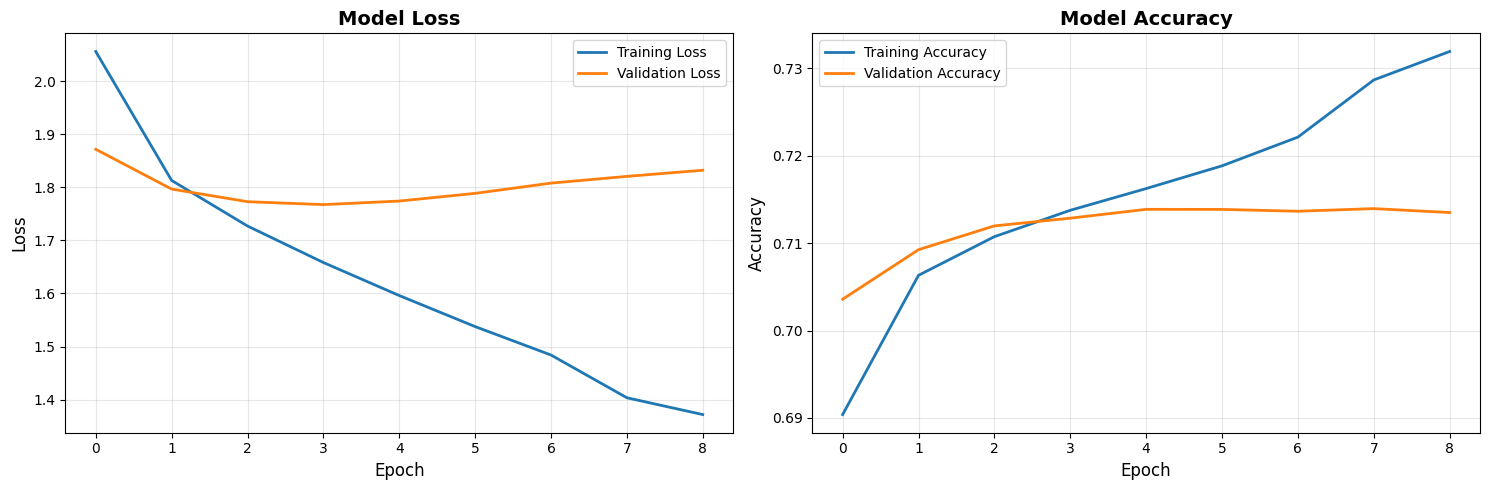

✓ Training plots saved to: logs/training_plots.png

TRAINING SUMMARY
Total epochs trained: 9
Final training loss: 1.3717
Final training accuracy: 0.7319
Final validation loss: 1.8324
Final validation accuracy: 0.7135
Best validation loss: 1.7676


In [87]:
#==============================================================================
# LOAD BEST MODEL
#==============================================================================

print("\nLoading best model...")
best_model = keras.models.load_model('models/best_model.keras')
print("✓ Best model loaded successfully")

#==============================================================================
# PLOT TRAINING HISTORY
#==============================================================================

print("\nGenerating training plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history.history:
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
if 'val_accuracy' in history.history:
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('logs/training_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training plots saved to: logs/training_plots.png")

#==============================================================================
# TRAINING SUMMARY
#==============================================================================

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")

if 'val_loss' in history.history:
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
else:
    print(f"Best training loss: {min(history.history['loss']):.4f}")

print("="*60)

In [93]:
questions = []  # Your input questions list
answers = []    # Your target answers list

# Create encoder tokenizer
print("Creating encoder tokenizer...")
encoder_tokenizer = Tokenizer(
    num_words=15000,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
encoder_tokenizer.fit_on_texts(questions)
print(f"✓ Encoder vocabulary size: {len(encoder_tokenizer.word_index)}")

# Create decoder tokenizer
print("Creating decoder tokenizer...")
decoder_tokenizer = Tokenizer(
    num_words=15000,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
decoder_tokenizer.fit_on_texts(answers)
print(f"✓ Decoder vocabulary size: {len(decoder_tokenizer.word_index)}")

# Save tokenizers
print("\nSaving tokenizers...")
with open('encoder_tokenizer.pkl', 'wb') as f:
    pickle.dump(encoder_tokenizer, f)

with open('decoder_tokenizer.pkl', 'wb') as f:
    pickle.dump(decoder_tokenizer, f)

print("✓ Tokenizers saved successfully!")
print("\nNow you can run the chatbot code.")

Creating encoder tokenizer...
✓ Encoder vocabulary size: 1
Creating decoder tokenizer...
✓ Decoder vocabulary size: 1

Saving tokenizers...
✓ Tokenizers saved successfully!

Now you can run the chatbot code.


In [ ]:
#==============================================================================
# LOAD MODEL
#==============================================================================

print("Loading trained model...")
model = keras.models.load_model('models/best_model.keras')
print("✓ Model loaded successfully\n")

#==============================================================================
# LOAD TOKENIZERS
#==============================================================================

# Load your tokenizers (make sure you saved them during training)
print("Loading tokenizers...")
try:
    with open('encoder_tokenizer.pkl', 'rb') as f:
        encoder_tokenizer = pickle.load(f)

    with open('decoder_tokenizer.pkl', 'rb') as f:
        decoder_tokenizer = pickle.load(f)

    print("✓ Tokenizers loaded successfully\n")
except FileNotFoundError:
    print("ERROR: Tokenizers not found!")
    print("Please save your tokenizers first:")
    print("""
    import pickle
    with open('encoder_tokenizer.pkl', 'wb') as f:
        pickle.dump(encoder_tokenizer, f)
    with open('decoder_tokenizer.pkl', 'wb') as f:
        pickle.dump(decoder_tokenizer, f)
    """)
    raise


In [ ]:

#==============================================================================
# CHATBOT CLASS
#==============================================================================

class Seq2SeqChatBot:
    def __init__(self, model, encoder_tokenizer, decoder_tokenizer,
                 max_encoder_seq_length=30, max_decoder_seq_length=29):
        """
        Initialize the Seq2Seq ChatBot

        Args:
            model: Trained Seq2Seq model
            encoder_tokenizer: Tokenizer for encoding input text
            decoder_tokenizer: Tokenizer for decoding output text
            max_encoder_seq_length: Maximum encoder sequence length (30)
            max_decoder_seq_length: Maximum decoder sequence length (29)
        """
        self.model = model
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_encoder_seq_length = max_encoder_seq_length
        self.max_decoder_seq_length = max_decoder_seq_length

        # Create reverse word index for decoder (token_id -> word)
        self.decoder_reverse_word_index = {
            v: k for k, v in decoder_tokenizer.word_index.items()
        }

        # Get special token indices
        self.start_token_id = decoder_tokenizer.word_index.get('start', 1)
        self.end_token_id = decoder_tokenizer.word_index.get('end', 2)

        print("="*60)
        print("CHATBOT INITIALIZED")
        print("="*60)
        print(f"Encoder vocabulary size: {len(encoder_tokenizer.word_index) + 1}")
        print(f"Decoder vocabulary size: {len(decoder_tokenizer.word_index) + 1}")
        print(f"Max encoder sequence length: {max_encoder_seq_length}")
        print(f"Max decoder sequence length: {max_decoder_seq_length}")
        print(f"Start token ID: {self.start_token_id}")
        print(f"End token ID: {self.end_token_id}")
        print("="*60 + "\n")

    def preprocess_input(self, text):
        """
        Preprocess user input text

        Args:
            text: Input text string

        Returns:
            Padded sequence ready for model input
        """
        # Convert to lowercase (if your training data was lowercase)
        text = text.lower().strip()

        # Tokenize the text
        sequences = self.encoder_tokenizer.texts_to_sequences([text])

        # Pad the sequence
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        padded = pad_sequences(
            sequences,
            maxlen=self.max_encoder_seq_length,
            padding='post'
        )

        return padded

    def decode_sequence_greedy(self, input_seq):
        """
        Decode input sequence using greedy search (faster but lower quality)

        Args:
            input_seq: Encoded input sequence

        Returns:
            Decoded response text
        """
        # Initialize decoder input with start token
        decoder_input = np.zeros((1, self.max_decoder_seq_length))
        decoder_input[0, 0] = self.start_token_id

        decoded_tokens = []

        # Generate tokens one by one
        for i in range(1, self.max_decoder_seq_length):
            # Predict next token
            predictions = self.model.predict(
                [input_seq, decoder_input],
                verbose=0
            )

            # Get token with highest probability at current position
            predicted_token_id = np.argmax(predictions[0, i-1, :])

            # Check for end token or padding
            if predicted_token_id == self.end_token_id or predicted_token_id == 0:
                break

            # Store the token
            decoded_tokens.append(predicted_token_id)

            # Update decoder input for next iteration
            if i < self.max_decoder_seq_length:
                decoder_input[0, i] = predicted_token_id

        # Convert token IDs to words
        decoded_words = []
        for token_id in decoded_tokens:
            word = self.decoder_reverse_word_index.get(token_id, '')
            # Skip special tokens
            if word and word not in ['start', 'end', 'unk']:
                decoded_words.append(word)

        return ' '.join(decoded_words) if decoded_words else "..."

    def decode_sequence_beam_search(self, input_seq, beam_width=3):
        """
        Decode using beam search for better quality responses

        Args:
            input_seq: Encoded input sequence
            beam_width: Number of beams to keep (higher = better quality but slower)

        Returns:
            Decoded response text
        """
        # Initialize beams: list of (sequence, score)
        beams = [([self.start_token_id], 0.0)]

        completed_beams = []

        # Generate tokens step by step
        for step in range(1, self.max_decoder_seq_length):
            all_candidates = []

            # Expand each beam
            for seq, score in beams:
                # Prepare decoder input
                decoder_input = np.zeros((1, self.max_decoder_seq_length))
                for j, token_id in enumerate(seq):
                    decoder_input[0, j] = token_id

                # Get predictions
                predictions = self.model.predict(
                    [input_seq, decoder_input],
                    verbose=0
                )

                # Get probabilities for next token
                next_token_probs = predictions[0, len(seq) - 1, :]

                # Get top-k candidates
                top_k_indices = np.argsort(next_token_probs)[-beam_width:]

                for token_id in top_k_indices:
                    if token_id == self.end_token_id:
                        # Sequence completed
                        completed_beams.append((seq[1:], score))  # Remove start token
                    else:
                        # Extend sequence
                        new_seq = seq + [token_id]
                        new_score = score - np.log(next_token_probs[token_id] + 1e-10)
                        all_candidates.append((new_seq, new_score))

            # Keep top beam_width candidates
            beams = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

            # Stop if we have enough completed beams
            if len(completed_beams) >= beam_width:
                break

        # Add remaining beams to completed
        for seq, score in beams:
            completed_beams.append((seq[1:], score))  # Remove start token

        # Select best completed beam
        if completed_beams:
            best_seq, _ = min(completed_beams, key=lambda x: x[1])
        else:
            best_seq = beams[0][0][1:] if beams else []

        # Convert to words
        decoded_words = []
        for token_id in best_seq:
            word = self.decoder_reverse_word_index.get(token_id, '')
            if word and word not in ['start', 'end', 'unk']:
                decoded_words.append(word)

        return ' '.join(decoded_words) if decoded_words else "..."

    def chat(self, user_input, use_beam_search=False, beam_width=3):
        """
        Generate a response to user input

        Args:
            user_input: User's message
            use_beam_search: Whether to use beam search (better quality but slower)
            beam_width: Beam width for beam search

        Returns:
            Bot's response
        """
        # Preprocess input
        input_seq = self.preprocess_input(user_input)

        # Generate response
        if use_beam_search:
            response = self.decode_sequence_beam_search(input_seq, beam_width)
        else:
            response = self.decode_sequence_greedy(input_seq)

        return response

    def interactive_chat(self, use_beam_search=False, beam_width=3):
        """
        Start an interactive chat session

        Args:
            use_beam_search: Whether to use beam search
            beam_width: Beam width for beam search
        """
        print("\n" + "="*60)
        print("INTERACTIVE CHAT SESSION")
        print("="*60)
        if use_beam_search:
            print(f"Using BEAM SEARCH (width={beam_width}) for better responses")
        else:
            print("Using GREEDY SEARCH (faster responses)")
        print("\nCommands:")
        print("  - Type your message and press Enter")
        print("  - Type 'quit', 'exit', or 'bye' to end")
        print("  - Type 'beam on' to enable beam search")
        print("  - Type 'beam off' to disable beam search")
        print("="*60 + "\n")

        while True:
            # Get user input
            user_input = input("You: ").strip()

            # Check for special commands
            if user_input.lower() in ['quit', 'exit', 'bye', 'goodbye']:
                print("\n" + "="*60)
                print("Bot: Goodbye! Thanks for chatting!")
                print("="*60)
                break

            if user_input.lower() == 'beam on':
                use_beam_search = True
                print("Bot: [Beam search enabled - higher quality responses]\n")
                continue

            if user_input.lower() == 'beam off':
                use_beam_search = False
                print("Bot: [Beam search disabled - faster responses]\n")
                continue

            # Skip empty inputs
            if not user_input:
                continue

            # Generate response
            try:
                response = self.chat(user_input, use_beam_search, beam_width)
                print(f"Bot: {response}\n")
            except Exception as e:
                print(f"Bot: [Error: {str(e)}]\n")

    def batch_chat(self, messages, use_beam_search=False, beam_width=3):
        """
        Process multiple messages at once

        Args:
            messages: List of user messages
            use_beam_search: Whether to use beam search
            beam_width: Beam width for beam search

        Returns:
            List of responses
        """
        responses = []

        print("\n" + "="*60)
        print("BATCH PROCESSING")
        print("="*60)

        for i, msg in enumerate(messages, 1):
            print(f"\n[{i}/{len(messages)}]")
            print(f"User: {msg}")

            response = self.chat(msg, use_beam_search, beam_width)
            responses.append(response)

            print(f"Bot: {response}")

        print("\n" + "="*60)
        print("BATCH PROCESSING COMPLETED")
        print("="*60)

        return responses


In [94]:

#==============================================================================
# INITIALIZE CHATBOT
#==============================================================================

chatbot = Seq2SeqChatBot(
    model=model,
    encoder_tokenizer=encoder_tokenizer,
    decoder_tokenizer=decoder_tokenizer,
    max_encoder_seq_length=30,
    max_decoder_seq_length=29
)

#==============================================================================
# USAGE EXAMPLES
#==============================================================================

print("\nCHATBOT READY TO USE!\n")
print("Example 1 - Single message:")
print("-" * 40)
user_msg = "hello"
bot_response = chatbot.chat(user_msg)
print(f"You: {user_msg}")
print(f"Bot: {bot_response}\n")

print("Example 2 - With beam search:")
print("-" * 40)
user_msg = "how are you"
bot_response = chatbot.chat(user_msg, use_beam_search=True, beam_width=5)
print(f"You: {user_msg}")
print(f"Bot: {bot_response}\n")

print("Example 3 - Batch processing:")
print("-" * 40)
test_messages = [
    "hello",
    "how are you",
    "what is your name",
    "goodbye"
]
responses = chatbot.batch_chat(test_messages, use_beam_search=False)

print("\n" + "="*60)
print("START INTERACTIVE CHAT")
print("="*60)
print("Run: chatbot.interactive_chat()")
print("or")
print("Run: chatbot.interactive_chat(use_beam_search=True, beam_width=5)")
print("="*60)


Loading trained model...
✓ Model loaded successfully

Loading tokenizers...
✓ Tokenizers loaded successfully

CHATBOT INITIALIZED
Encoder vocabulary size: 2
Decoder vocabulary size: 2
Max encoder sequence length: 30
Max decoder sequence length: 29
Start token ID: 1
End token ID: 2


CHATBOT READY TO USE!

Example 1 - Single message:
----------------------------------------
You: hello
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

Example 2 - With beam search:
----------------------------------------
You: how are you
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

Example 3 - Batch processing:
----------------------------------------

BATCH PROCESSING

[1/4]
User: hello
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

[2/4]
User: how

In [95]:
chatbot.interactive_chat(use_beam_search=True, beam_width=5)


INTERACTIVE CHAT SESSION
Using BEAM SEARCH (width=5) for better responses

Commands:
  - Type your message and press Enter
  - Type 'quit', 'exit', or 'bye' to end
  - Type 'beam on' to enable beam search
  - Type 'beam off' to disable beam search

You: Hello how are you?
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

You: hello
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

You: beam off
Bot: [Beam search disabled - faster responses]

You: Hello how are you
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

You: beam on
Bot: [Beam search enabled - higher quality responses]

You: are you well?
Bot: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

You: bye

Bot: Goodbye! Thanks for chatting!
